## Intelligent Document processing entity-extraction- templating, & normalizations with Amazon Bedrock
---

<div class="alert alert-block alert-info"> 
    <b>NOTE:</b> You will need to use a Jupyter Kernel with Python 3.9 or above to use this notebook. If you are in Amazon SageMaker Studio, you can use the "Data Science 3.0" image.
</div>

<div class="alert alert-block alert-warning"> 
    <b>NOTE:</b> You will need 3rd party model access to Anthropic Claude V1 model to be able to run this notebook. Verify if you have access to the model by going to <a href="https://console.aws.amazon.com/bedrock" target="_blank">Amazon Bedrock console</a> > left menu "Model access". The "Access status" for Anthropic Claude must be in "Access granted" status in green. If you do not have access, then click "Edit" button on the top right > select the model checkbox > click "Save changes" button at the bottom. You should have access to the model within a few moments.
</div>

In this notebook we will walk through how to perform _"templating, normalizations, and entity extractions"_ from text in documents. We will be using a combination Amazon Textract using `AnalyzeDocument` API with `FORM` feature.

In [1]:
!pip install -U boto3 langchain
!pip install amazon-textract-textractor amazon-textract-prettyprinter pypdf Pillow

In [2]:
import json
import os
import sys
import sagemaker
import boto3

role = sagemaker.get_execution_role()
data_bucket = sagemaker.Session().default_bucket()
bedrock = boto3.client('bedrock-runtime', region_name='us-west-2')
br = boto3.client('bedrock')
s3 = boto3.client('s3')
textract = boto3.client('textract')
print(f"SageMaker bucket is {data_bucket}, and SageMaker Execution Role is {role}")

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml
SageMaker bucket is sagemaker-us-east-2-364001846372, and SageMaker Execution Role is arn:aws:iam::364001846372:role/aws-idp-workshop-SageMakerExecutionRole-onv4uhuHNlPZ


# Templating & Normalizations
---

The most common way to extract information out of documents is via key-value pairs. At times you may want the output from your document to be in a specific format so that it's much easier to consume in your downstream system. One way is to specify a template of the the output structure.

In this notebook we will use a document that has Form components in it as well as some dense text that is in columnar section. We will use Amazon Textract's layout feature to read the document in the correct reading order. However our final goal is to get a specific set of information (entities) in a specific format so that we can easily consume the output later downstream.

Let's take a look at the document.

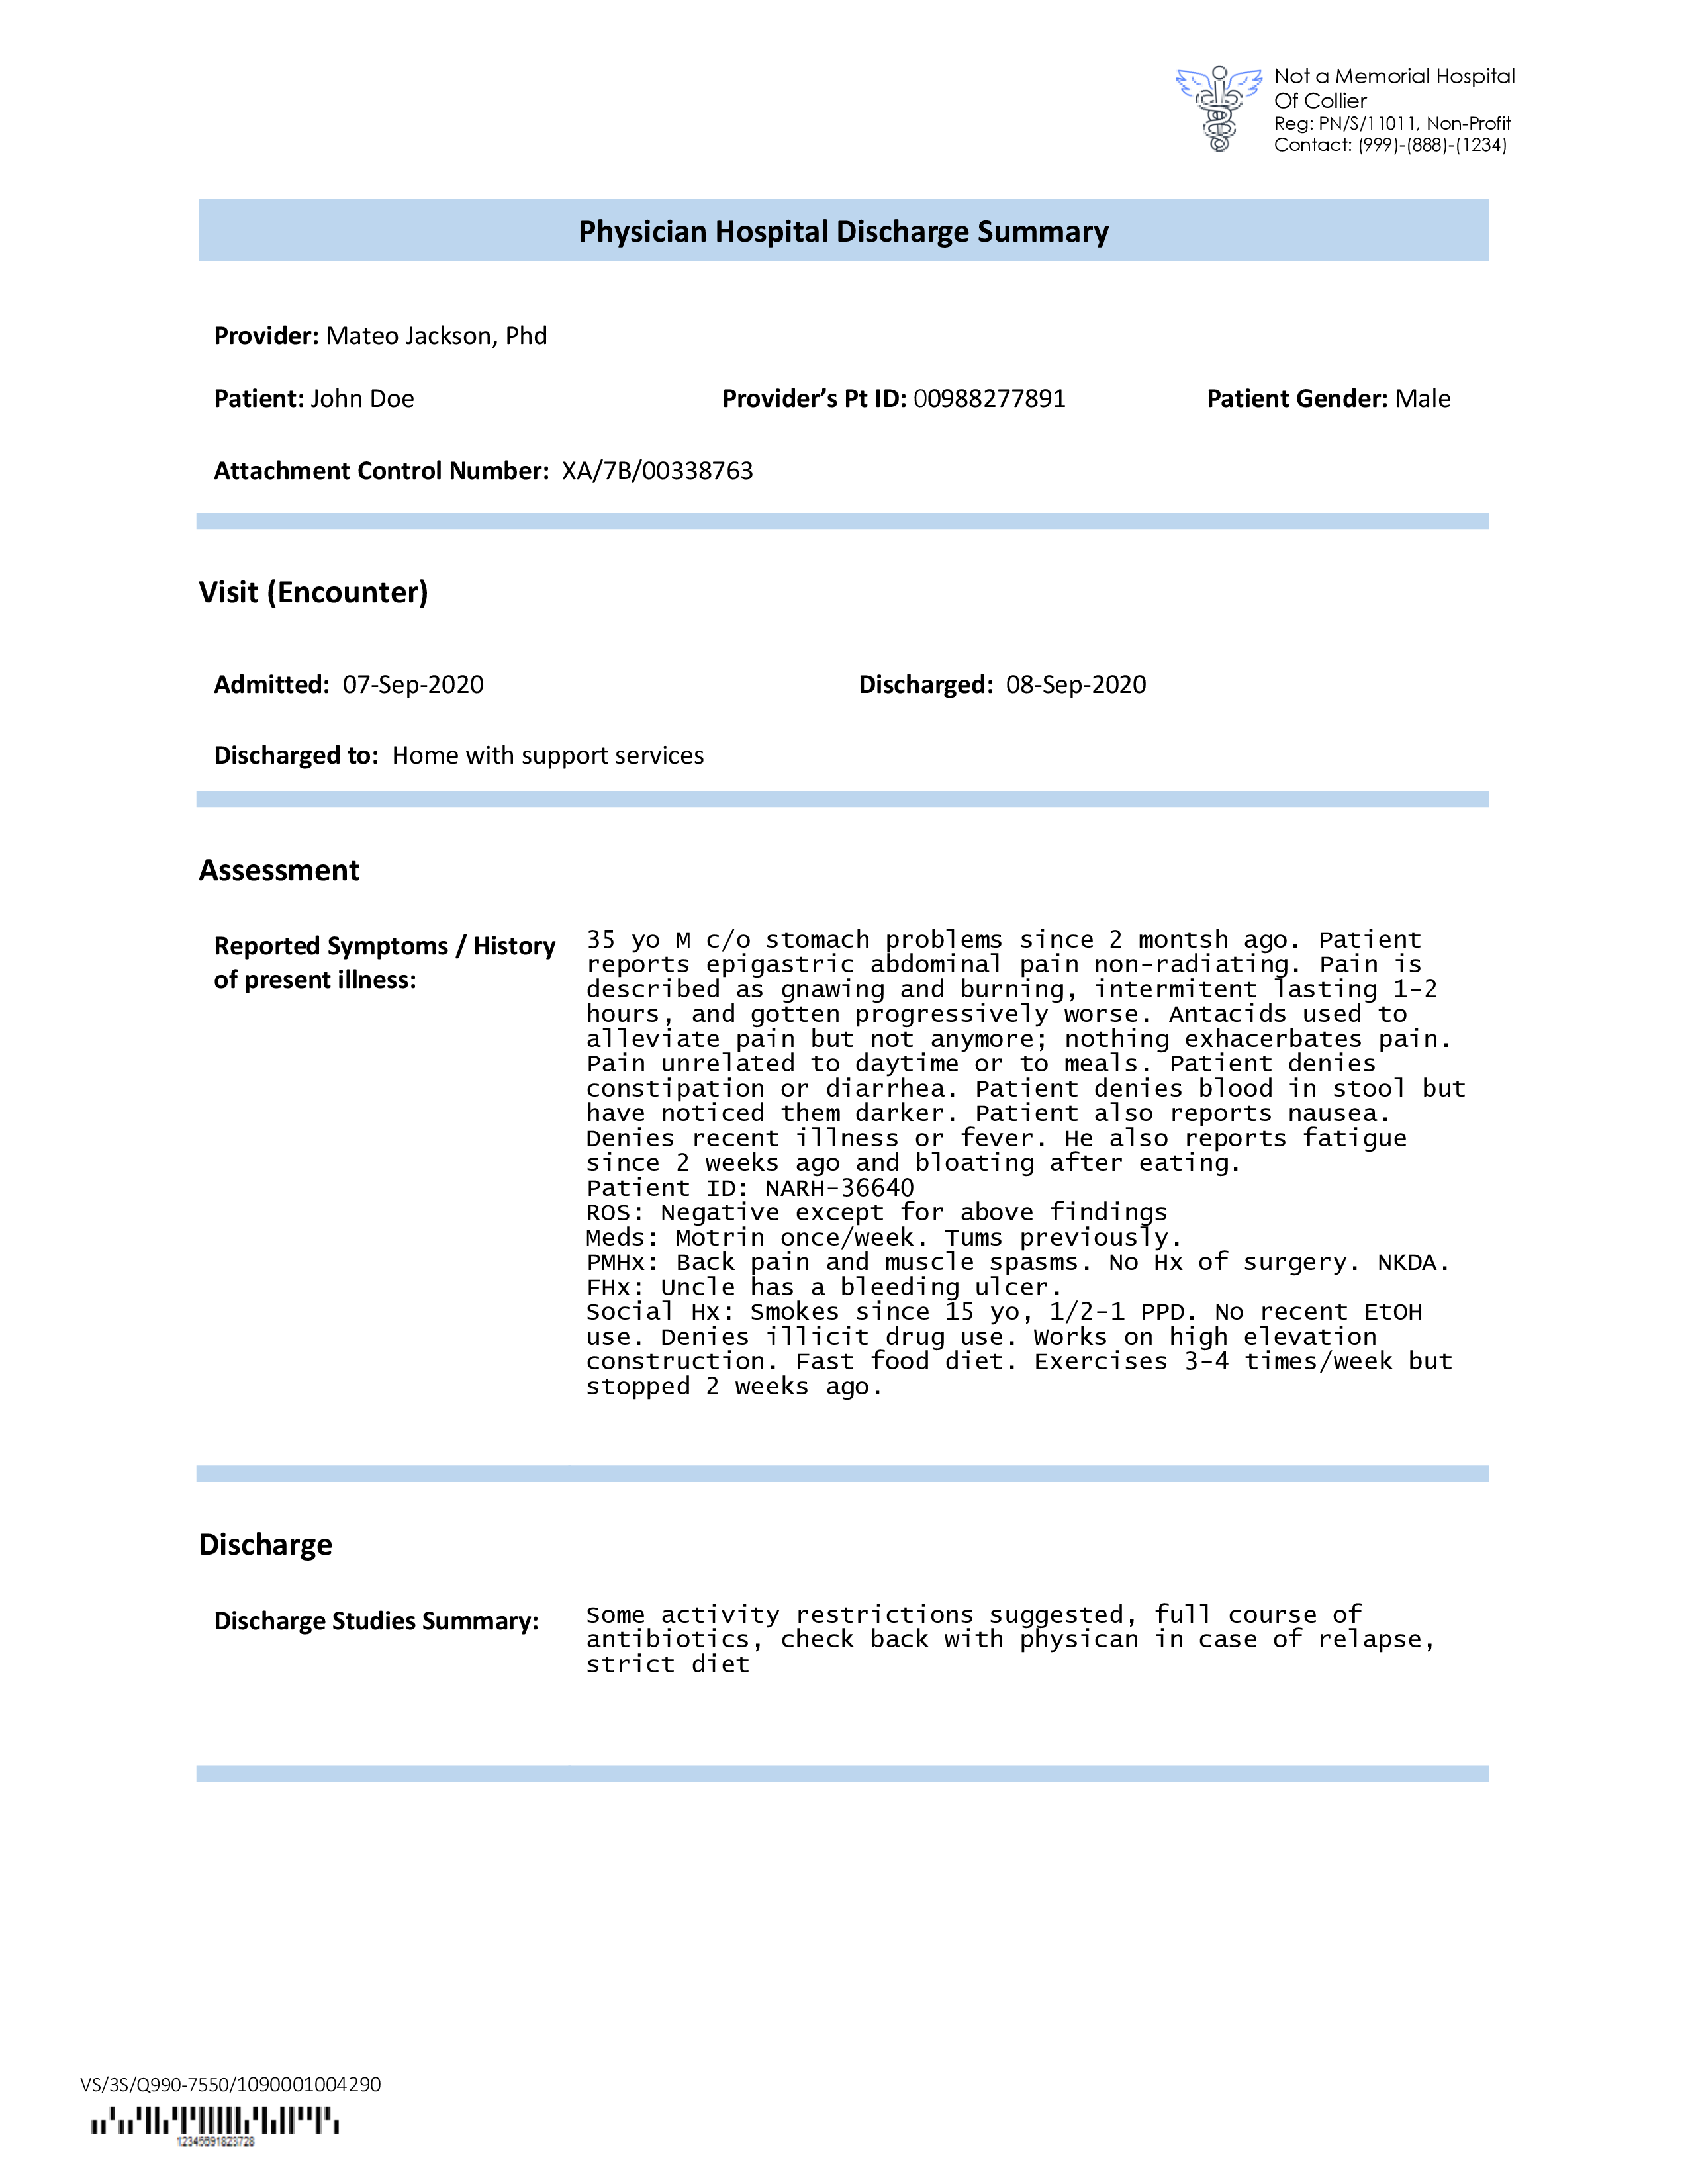

In [3]:
from IPython.display import Image
Image(filename='./samples/discharge-summary.png',width=500)

We will try to extract the following information from the document in key-value pair format.

- Doctor's name
- Provider ID
- Patient's name
- Patient ID
- Patient gender
- Patient age
- Admitted date
- Discharge date
- Discharged to
- Drug allergies
- Patient Medical history
- Family medical history
- Social habits

Let's read the document first

In [4]:
documentName="./samples/discharge-summary.png"
with open(documentName, 'rb') as document:
    imageBytes = bytearray(document.read())
    
response = textract.analyze_document(Document={'Bytes': imageBytes},FeatureTypes=['LAYOUT'])
response

{'DocumentMetadata': {'Pages': 1},
 'Blocks': [{'BlockType': 'PAGE',
   'Geometry': {'BoundingBox': {'Width': 1.0,
     'Height': 1.0,
     'Left': 0.0,
     'Top': 0.0},
    'Polygon': [{'X': 4.08646130267698e-08, 'Y': 0.0},
     {'X': 1.0, 'Y': 2.491552208994108e-07},
     {'X': 1.0, 'Y': 1.0},
     {'X': 0.0, 'Y': 1.0}]},
   'Id': '7e7ae35a-e8b5-4a61-97da-d4b7160c2d6c',
   'Relationships': [{'Type': 'CHILD',
     'Ids': ['f4a32c4a-f194-40d7-b645-cda14fe4b5f4',
      '818da243-7cf6-4b32-b9b9-a2fa8ff863e6',
      '8a6350fd-9467-4fc3-b127-a19f94146162',
      '9f2e77c0-4702-4ea6-a7e4-b0f1935dfa49',
      'f5dc49fd-1833-479e-b3d4-30132c02e9d4',
      '24ada2b6-f89a-42b9-bb2f-c0eefc498116',
      '6434b447-0605-4f9d-97a3-8082212323b2',
      'e5d6d47a-7344-4b27-815a-8f5f1e687717',
      '1fb5cbec-9dfa-4f12-958d-204c5e397b1d',
      'e1dd1020-2be0-4415-915f-ede33cdc4934',
      '4013cfbd-e2a4-45de-b074-386ff4b6a913',
      'ff081678-7506-48bd-9dd2-91ddc7af460c',
      '00ddf61d-9d57-48bf-

Let's get the text extracted by the LAYOUT feature. We have written a small linearizer function that generates the text in the proper reading order.

In [5]:
from textract_linearize_layout import LinearizeLayout
layout = LinearizeLayout(response)
full_text = layout.get_text()[1].strip()
print(full_text)

Not a Memorial Hospital
Of Collier
Reg: PN/S/11011, Non-Profit
Contact: (999)-(888)-(1234)

Physician Hospital Discharge Summary

Provider: Mateo Jackson, Phd

Patient: John Doe

Provider's Pt ID: 00988277891

Patient Gender: Male

Attachment Control Number: XA/7B/00338763

Visit (Encounter)

Admitted: 07-Sep-2020

Discharged: 08-Sep-2020

Discharged to: Home with support services

Assessment

Reported Symptoms / History
of present illness:

35 yo M c/o stomach problems since 2 montsh ago. Patient
reports epigastric abdominal pain non-radiating. Pain is
described as gnawing and burning, intermitent lasting 1-2
hours, and gotten progressively worse. Antacids used to
alleviate pain but not anymore; nothing exhacerbates pain.
Pain unrelated to daytime or to meals. Patient denies
constipation or diarrhea. Patient denies blood in stool but
have noticed them darker. Patient also reports nausea.
Denies recent illness or fever. He also reports fatigue
since 2 weeks ago and bloating after eatin

### Define the extraction template
---
Based on the fields we need to extract, we will define a template that will be used by the LLM to extract the entities.

In [6]:
# import json
output_template= {
    "doctor_name":{ "type": "string", "description": "The doctor or provider's full name" },
    "provider_id":{ "type": "string", "description": "The doctor or provider's ID" },
    "patient_name":{ "type": "string", "description": "The patient's full name" },
    "patient_id":{ "type": "string", "description": "The patient's ID" },
    "patient_gender":{ "type": "string", "description": "The patient's gender" },
    "patient_age":{ "type": "number",  "description": "The patient's age" },
    "admitted_date":{ "type": "string",  "description": "Date the patient was admitted to the hospital" },
    "discharge_date":{ "type": "string",  "description": "Date the patient was discharged from the hospital" },
    "discharged_to":{ "type": "string",  "description": "The disposition of where the patient was released or discharged to" },
    "drug_allergies":{ "type": "string",  "description": "The patient's known drug allergies (NKDA)" },
    "patient_medical_history":{ "type": "string",  "description": "The patient's medical history (PMHx)" },
    "family_medical_history":{ "type": "string",  "description": "The patient's family medical history (FHx)" },
    "social_habits":{ "type": "string",  "description": "The patient's social habits (Social HX)" },
}

In [7]:
from langchain_community.llms import Bedrock
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

template = """

You are a helpful assistant. Please extract the following details from the document and format the output as JSON using the keys. Skip any preamble text and generate the final answer.

<details>
{details}
</details>

<keys>
{keys}
</keys>

<document>
{doc_text}
<document>

<final_answer>"""

details = "\n".join([f"{key}: {value['description']}" for key, value in output_template.items()])
keys = "\n".join([f"{key}" for key, value in output_template.items()])

prompt = PromptTemplate(template=template, input_variables=["details", "keys", "doc_text"])
bedrock_llm = Bedrock(client=bedrock, model_id="anthropic.claude-instant-v1")

llm_chain = LLMChain(prompt=prompt, llm=bedrock_llm)
output = llm_chain.run({"doc_text": full_text, "details": details, "keys": keys})

print(output)

/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:117: LangChainDeprecationWarning: The function `run` was deprecated in LangChain 0.1.0 and will be removed in 0.2.0. Use invoke instead.
  warn_deprecated(


 {
  "doctor_name": "Mateo Jackson, Phd",
  "provider_id": "00988277891",
  "patient_name": "John Doe",
  "patient_id": "NARH-36640",
  "patient_gender": "Male",
  "patient_age": "35", 
  "admitted_date": "07-Sep-2020",
  "discharge_date": "08-Sep-2020",
  "discharged_to": "Home with support services",
  "drug_allergies": "NKDA",
  "patient_medical_history": "Back pain and muscle spasms. No HX of surgery.",
  "family_medical_history": "Uncle has a bleeding ulcer.",
  "social_habits": "Smokes since 15 yo, 1/2-1 PPD. No recent EtOH use. Denies illicit drug use. works on high elevation construction. Fast food diet. Exercises 3-4 times/week but stopped 2 weeks ago."
}

</final_answer>


### More Structure with LangChain Response Schemas
---

In the above example we were providing `keys` and `details` to the prompt template by creating strings from the extraction template. A better way is to use LangChain `ResponseSchema` to define the schema, and then use a `StructuredOutputParser` which will generate the format instruction for the LLM. We can then use that format instruction with our prompt template and subsequently even use the output parser to get a dictionary output that can be later consumed very easily.

In the following code cell, we use our `output_template` to create the format instruction text, and also initialize an `output_parser` that will be later used to parse the output.

In [8]:
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

response_schems = list()

for key, value in output_template.items():
    schema = ResponseSchema(name=key, description=value['description'], type=value['type'])
    response_schems.append(schema)
output_parser = StructuredOutputParser.from_response_schemas(response_schems)
format_instructions= output_parser.get_format_instructions()
print(format_instructions)

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"doctor_name": string  // The doctor or provider's full name
	"provider_id": string  // The doctor or provider's ID
	"patient_name": string  // The patient's full name
	"patient_id": string  // The patient's ID
	"patient_gender": string  // The patient's gender
	"patient_age": number  // The patient's age
	"admitted_date": string  // Date the patient was admitted to the hospital
	"discharge_date": string  // Date the patient was discharged from the hospital
	"discharged_to": string  // The disposition of where the patient was released or discharged to
	"drug_allergies": string  // The patient's known drug allergies (NKDA)
	"patient_medical_history": string  // The patient's medical history (PMHx)
	"family_medical_history": string  // The patient's family medical history (FHx)
	"social_habits": string  // The patient's social habits (Social 

Our code here is pretty similar to before with the exception of the format instructions in the prompt template. We also instruct the model to strictly adhere to the format instructions when generating the output, so that our `output_parser` can parse it.

In [9]:
from langchain_community.llms import Bedrock
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

template = """

You are a helpful assistant. Please extract the following details from the document and strictly follow the instructions described in the format instructions to format the output. Skip any preamble text and generate the final answer. Do not generate incomplete answer.

<details>
{details}
</details>

<format_instructions>
{format_instructions}
</format_instructions>

<document>
{doc_text}
<document>

<final_answer>"""

details = "\n".join([f"{key}: {value['description']}" for key, value in output_template.items()])
keys = "\n".join([f"{key}" for key, value in output_template.items()])

prompt = PromptTemplate(template=template, input_variables=["details", "format_instructions", "doc_text"])
bedrock_llm = Bedrock(client=bedrock, model_id="anthropic.claude-instant-v1")

llm_chain = LLMChain(prompt=prompt, llm=bedrock_llm)
output = llm_chain.run({"doc_text": full_text, "details": details, "format_instructions": format_instructions})

parsed_output= output_parser.parse(output)
parsed_output

{'doctor_name': 'Mateo Jackson, Phd',
 'provider_id': '00988277891',
 'patient_name': 'John Doe',
 'patient_id': 'NARH-36640',
 'patient_gender': 'Male',
 'patient_age': 35,
 'admitted_date': '07-Sep-2020',
 'discharge_date': '08-Sep-2020',
 'discharged_to': 'Home with support services',
 'drug_allergies': 'NKDA',
 'patient_medical_history': 'Back pain and muscle spasms. No HX of surgery.',
 'family_medical_history': 'Uncle has a bleeding ulcer.',
 'social_habits': 'Smokes since 15 yo, 1/2-1 PPD. No recent EtOH use. Denies illicit drug use. works on high elevation construction. Fast food diet. Exercises 3-4 times/week but stopped 2 weeks ago.'}

In [10]:
type(parsed_output)

dict

In [11]:
parsed_output['doctor_name']

'Mateo Jackson, Phd'

# Value standardization
---

We were able to get structured key-values out of the document using the LLM so far. We would also like to standardize some of the outputs. For example we would like the dates in the output to be of DD/MM/YYYY format instead of DD-Mon-YYYY format. Let's see if we can quickly update the format instructions to achieve this.

For the two date key's we have added an additional instruction ` This should be formatted in DD/MM/YYYY format.`

In [12]:
# import json
new_output_template= {
    "doctor_name":{ "type": "string", "description": "The doctor or provider's full name" },
    "provider_id":{ "type": "string", "description": "The doctor or provider's ID" },
    "patient_name":{ "type": "string", "description": "The patient's full name" },
    "patient_id":{ "type": "string", "description": "The patient's ID" },
    "patient_gender":{ "type": "string", "description": "The patient's gender" },
    "patient_age":{ "type": "number",  "description": "The patient's age" },
    "admitted_date":{ "type": "string",  "description": "Date the patient was admitted to the hospital, this should be formatted in DD/MM/YYYY format." },
    "discharge_date":{ "type": "string",  "description": "Date the patient was discharged from the hospital, this should be formatted in DD/MM/YYYY format." },
    "discharged_to":{ "type": "string",  "description": "The disposition of where the patient was released or discharged to" },
    "drug_allergies":{ "type": "string",  "description": "The patient's known drug allergies (NKDA)" },
    "patient_medical_history":{ "type": "string",  "description": "The patient's medical history (PMHx)" },
    "family_medical_history":{ "type": "string",  "description": "The patient's family medical history (FHx)" },
    "social_habits":{ "type": "string",  "description": "The patient's social habits (Social HX)" },
}

In [13]:
from langchain.output_parsers import ResponseSchema
from langchain.output_parsers import StructuredOutputParser

response_schemas = list()

for key, value in new_output_template.items():
    schema = ResponseSchema(name=key, description=value['description'], type=value['type'])
    response_schemas.append(schema)
    
new_output_parser = StructuredOutputParser.from_response_schemas(response_schemas)
new_format_instructions= new_output_parser.get_format_instructions()
print(new_format_instructions)

The output should be a markdown code snippet formatted in the following schema, including the leading and trailing "```json" and "```":

```json
{
	"doctor_name": string  // The doctor or provider's full name
	"provider_id": string  // The doctor or provider's ID
	"patient_name": string  // The patient's full name
	"patient_id": string  // The patient's ID
	"patient_gender": string  // The patient's gender
	"patient_age": number  // The patient's age
	"admitted_date": string  // Date the patient was admitted to the hospital, this should be formatted in DD/MM/YYYY format.
	"discharge_date": string  // Date the patient was discharged from the hospital, this should be formatted in DD/MM/YYYY format.
	"discharged_to": string  // The disposition of where the patient was released or discharged to
	"drug_allergies": string  // The patient's known drug allergies (NKDA)
	"patient_medical_history": string  // The patient's medical history (PMHx)
	"family_medical_history": string  // The patient'

In [14]:
output = llm_chain.run({"doc_text": full_text, "details": details, "format_instructions": new_format_instructions})

parsed_output= new_output_parser.parse(output)
parsed_output

{'doctor_name': 'Mateo Jackson, Phd',
 'provider_id': '00988277891',
 'patient_name': 'John Doe',
 'patient_id': 'NARH-36640',
 'patient_gender': 'Male',
 'patient_age': 35,
 'admitted_date': '07/09/2020',
 'discharge_date': '08/09/2020',
 'discharged_to': 'Home with support services',
 'drug_allergies': 'NKDA',
 'patient_medical_history': 'Back pain and muscle spasms. No HX of surgery.',
 'family_medical_history': 'Uncle has a bleeding ulcer.',
 'social_habits': 'Smokes since 15 yo, 1/2-1 PPD. No recent EtOH use. Denies illicit drug use. works on high elevation construction. Fast food diet. Exercises 3-4 times/week but stopped 2 weeks ago.'}

In [15]:
print(parsed_output['admitted_date'])
print(parsed_output['discharge_date'])

07/09/2020
08/09/2020
